<a href="https://colab.research.google.com/github/tashir0605/SentimentSphere/blob/main/Emotion%20Through%20Text/Human_Emotion_through_text.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# Text Emotion Detection

In [28]:
import re
import nltk
import string
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer, WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Dense, LSTM, Embedding, Bidirectional

nltk.download("stopwords")
stop_words = set(stopwords.words("english"))
lemmatizer= WordNetLemmatizer()

# Modelling
# from sklearn.model_selection import train_test_split,KFold, GridSearchCV
# from sklearn.ensemble import RandomForestClassifier
# from sklearn.linear_model import LogisticRegression
# from sklearn.tree import DecisionTreeClassifier
# from sklearn.ensemble import RandomForestClassifier
# from sklearn.metrics import accuracy_score,confusion_matrix, classification_report
# from sklearn.pipeline import Pipeline
# from sklearn.metrics import f1_score
# from sklearn.svm import SVC

#Lime
!pip install lime
from lime import lime_text
from lime.lime_text import LimeTextExplainer
from lime.lime_text import IndexedString,IndexedCharacters
from lime.lime_base import LimeBase
from lime.lime_text import explanation
sns.set(font_scale=1.3)
nltk.download('omw-1.4')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

**Dataset**

In [29]:
df=pd.read_csv("text_emotion_dataset_raw.csv")

In [30]:
df.head()

,Emotion,Text
0,neutral,Why ?
1,joy,Sage Act upgrade on my to do list for tommorow.
2,sadness,ON THE WAY TO MY HOMEGIRL BABY FUNERAL!!! MAN ...
3,joy,Such an eye ! The true hazel eye-and so brill...
4,joy,@Iluvmiasantos ugh babe.. hugggzzz for u .! b...


In [31]:
print(df.shape)

(34792, 2)


In [32]:
df['Emotion'].value_counts()

,count
Emotion,
joy,11045
sadness,6722
fear,5410
anger,4297
surprise,4062
neutral,2254
disgust,856
shame,146


<Axes: xlabel='Emotion', ylabel='count'>

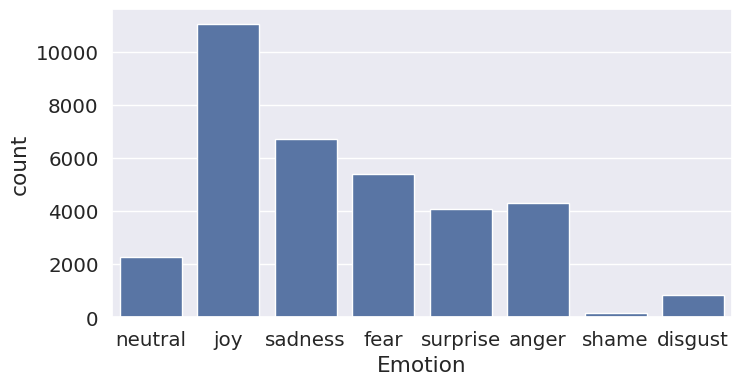

In [33]:
plt.figure(figsize=(8,4))
sns.countplot(x='Emotion',data=df)


In [34]:
df.Emotion.value_counts() / df.shape[0] *100

,count
Emotion,
joy,31.745804
sadness,19.320533
fear,15.549552
anger,12.350540
surprise,11.675098
neutral,6.478501
disgust,2.460336
shame,0.419637


In [35]:
#print the number of null values in each column
df.isnull().sum()

,0
Emotion,0
Text,0


In [36]:
#print the number of duplicated values
df.duplicated().sum()

3630

In [37]:
#removing duplicated values
index = df[df.duplicated() == True].index
df.drop(index, axis = 0, inplace = True)
df.reset_index(inplace=True, drop = True)

In [38]:
df.shape

(31162, 2)

There is just 3630 row which is duplicated but we need to check also if there are rows having the same text but different emotions

In [39]:
#print the rows which are duplicated (duplicated in the text but with different emotions)
df[df['Text'].duplicated() == True]

,Emotion,Text
1017,neutral,See you .
2994,joy,Yes .
5063,joy,Thank you very much .
5808,neutral,Certainly .
6054,neutral,No .
7138,joy,Okay .
8130,joy,Bye .
8797,neutral,All right .
9157,joy,Thanks .
10045,anger,Why not ?


In [40]:
#print some rows to check
df[df['Text'] == df.iloc[13452]['Text']]
df[df['Text'] == df.iloc[28067]['Text']]
df[df['Text'] == df.iloc[30193]['Text']]

,Emotion,Text
19835,joy,Just had a great movie marathon with my wonder...
30193,fear,Just had a great movie marathon with my wonder...


In [41]:
# Check which texts have conflicting emotions
conflicting_texts = df.groupby("Text")["Emotion"].nunique()
conflicting_texts = conflicting_texts[conflicting_texts > 1]  # Keep only those with more than 1 unique emotion

# Print conflicts
print(df[df["Text"].isin(conflicting_texts.index)])

# Now, let's keep only the most frequent emotion for each text
df = df.groupby("Text").agg(lambda x: x.value_counts().idxmax()).reset_index()

# Print new shape after handling duplicates properly
print(df.shape)


       Emotion                                               Text
267    sadness   Totally not . Perhaps it's about our marriage . 
312    neutral                                              OK . 
387    neutral                                        OK . Bye ! 
560        joy                                       Certainly . 
661    neutral                                             Bye . 
...        ...                                                ...
28067      joy                                            Sure . 
28689  neutral   It ’ s true . Michelle is a lot like Henry in...
30193     fear  Just had a great movie marathon with my wonder...
30210     fear                 Frightened ? You must be joking . 
30345      joy  Rescued dogs are often somewhat nervous of peo...

[102 rows x 2 columns]
(31110, 2)


In [43]:
print(df["Text"].duplicated().sum())  # Should be 0 if all duplicates were removed


0


In [44]:
conflicts = df.groupby("Text")["Emotion"].nunique()
print(conflicts[conflicts > 1])  # Should show if any text had multiple emotions


Series([], Name: Emotion, dtype: int64)


In [42]:
#Count the number of stopwords in the data
temp =df.copy()
stop_words = set(stopwords.words("english"))
temp['stop_words'] = temp['Text'].apply(lambda x: len(set(x.split()) & set(stop_words)))
temp.stop_words.value_counts()

,count
stop_words,
4,3756
5,3573
3,3494
2,3197
6,3126
7,2571
0,2377
1,2373
8,2027


The data contains alot of stopwords (some rows contains more than 25 stopword!) so, we need to take care when we remove them as some rows may become empty

<Axes: ylabel='Frequency'>

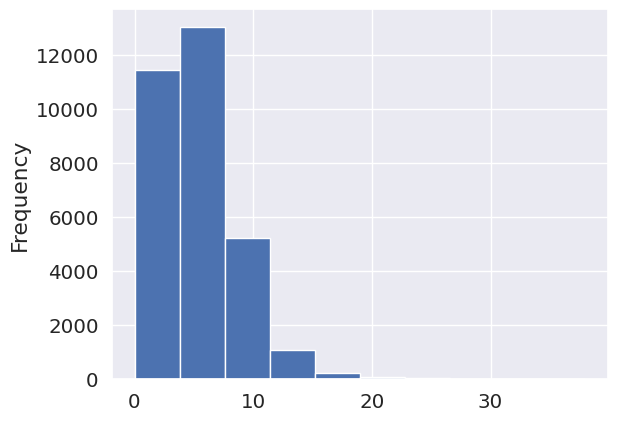

In [45]:
#distribution of stopwords visually
temp['stop_words'].plot(kind= 'hist')

# Compare rows of the datasets

Check that there is no data leakage

In [46]:
def dataframe_difference(df1, df2, which=None):
    """Find rows which are different between two DataFrames."""

    comparison_df = df1.merge(
        df2,
        indicator=True,
        how='outer'
    )

    if which is None:
        diff_df = comparison_df[comparison_df['_merge'] != 'both']
    else:
        diff_df = comparison_df[comparison_df['_merge'] == which]

    # Return the filtered DataFrame
    return diff_df

# Cleaning

In [49]:
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [50]:
def lemmatization(text):
    lemmatizer= WordNetLemmatizer()

    text = text.split()

    text=[lemmatizer.lemmatize(y) for y in text]

    return " " .join(text)

def remove_stop_words(text):

    Text=[i for i in str(text).split() if i not in stop_words]
    return " ".join(Text)

def Removing_numbers(text):
    text=''.join([i for i in text if not i.isdigit()])
    return text

def lower_case(text):

    text = text.split()

    text=[y.lower() for y in text]

    return " " .join(text)

def Removing_punctuations(text):
    ## Remove punctuations
    text = re.sub('[%s]' % re.escape("""!"#$%&'()*+,،-./:;<=>؟?@[\]^_`{|}~"""), ' ', text)
    text = text.replace('؛',"", )

    ## remove extra whitespace
    text = re.sub('\s+', ' ', text)
    text =  " ".join(text.split())
    return text.strip()

def Removing_urls(text):
    url_pattern = re.compile(r'https?://\S+|www\.\S+')
    return url_pattern.sub(r'', text)

def remove_small_sentences(df):
    for i in range(len(df)):
        if len(df.text.iloc[i].split()) < 3:
            df.text.iloc[i] = np.nan

def normalize_text(df):
    df.Text=df.Text.apply(lambda text : lower_case(text))
    df.Text=df.Text.apply(lambda text : remove_stop_words(text))
    df.Text=df.Text.apply(lambda text : Removing_numbers(text))
    df.Text=df.Text.apply(lambda text : Removing_punctuations(text))
    df.Text=df.Text.apply(lambda text : Removing_urls(text))
    df.Text=df.Text.apply(lambda text : lemmatization(text))
    return df

def normalized_sentence(sentence):
    sentence= lower_case(sentence)
    sentence= remove_stop_words(sentence)
    sentence= Removing_numbers(sentence)
    sentence= Removing_punctuations(sentence)
    sentence= Removing_urls(sentence)
    sentence= lemmatization(sentence)
    return sentence

In [51]:
df= normalize_text(df)

In [52]:
normalized_sentence("My Name is _Maysaa. @Tweets,  ")

'name maysaa tweet'

**Data pre-processing**

In Natural Language Processing (NLP), **neattext** refers to a Python library designed to provides a set of simple and easy-to-use functions for cleaning, formatting, and processing text data.

**Some of the common functionalities offered by the neattext library include:**

1. Removing special characters and unwanted symbols

2. Normalization: This includes tasks like converting text to lowercase, expanding contractions (e.g., changing "I'm" to "I am"), and removing stopwords (common words like "the", "is", etc. that don’t add much meaning in NLP tasks).

3. Handling tokenization: neattext can tokenize a given sentence into words, which is useful for many downstream NLP tasks.

4. Text formatting: It provides tools for removing extra whitespaces, line breaks, and formatting issues.

In [ ]:
!pip install neattext


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.7/114.7 kB 9.8 MB/s eta 0:00:00


In [ ]:
import neattext.functions as nfx

**User handles** in this case are references to social media usernames, which typically begin with an "@" symbol (e.g., @username).

In [ ]:
df['Clean_Text']=df['Text'].apply(nfx.remove_userhandles)

In [ ]:
df

,Emotion,Text,Clean_Text
0,neutral,Why ?,Why ?
1,joy,Sage Act upgrade on my to do list for tommorow.,Sage Act upgrade on my to do list for tommorow.
2,sadness,ON THE WAY TO MY HOMEGIRL BABY FUNERAL!!! MAN ...,ON THE WAY TO MY HOMEGIRL BABY FUNERAL!!! MAN ...
3,joy,Such an eye ! The true hazel eye-and so brill...,Such an eye ! The true hazel eye-and so brill...
4,joy,@Iluvmiasantos ugh babe.. hugggzzz for u .! b...,ugh babe.. hugggzzz for u .! babe naamazed ...
...,...,...,...
34787,surprise,@MichelGW have you gift! Hope you like it! It'...,have you gift! Hope you like it! It's hand m...
34788,joy,The world didnt give it to me..so the world MO...,The world didnt give it to me..so the world MO...
34789,anger,A man robbed me today .,A man robbed me today .
34790,fear,"Youu call it JEALOUSY, I call it of #Losing YO...","Youu call it JEALOUSY, I call it of #Losing YO..."


Code to see the Functions under neattext

In [ ]:
dir(nfx)

['BTC_ADDRESS_REGEX',
 'CURRENCY_REGEX',
 'CURRENCY_SYMB_REGEX',
 'Counter',
 'DATE_REGEX',
 'EMAIL_REGEX',
 'EMOJI_REGEX',
 'HASTAG_REGEX',
 'MASTERCard_REGEX',
 'MD5_SHA_REGEX',
 'MOST_COMMON_PUNCT_REGEX',
 'NUMBERS_REGEX',
 'PHONE_REGEX',
 'PoBOX_REGEX',
 'SPECIAL_CHARACTERS_REGEX',
 'STOPWORDS',
 'STOPWORDS_de',
 'STOPWORDS_en',
 'STOPWORDS_es',
 'STOPWORDS_fr',
 'STOPWORDS_ru',
 'STOPWORDS_yo',
 'STREET_ADDRESS_REGEX',
 'TextFrame',
 'URL_PATTERN',
 'USER_HANDLES_REGEX',
 'VISACard_REGEX',
 '__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__generate_text',
 '__loader__',
 '__name__',
 '__numbers_dict',
 '__package__',
 '__spec__',
 '_lex_richness_herdan',
 '_lex_richness_maas_ttr',
 'clean_text',
 'defaultdict',
 'digit2words',
 'extract_btc_address',
 'extract_currencies',
 'extract_currency_symbols',
 'extract_dates',
 'extract_emails',
 'extract_emojis',
 'extract_hashtags',
 'extract_html_tags',
 'extract_mastercard_addr',
 'extract_md5sha',
 'extract_numbers',
 'extr

In [ ]:
# Remove the Stopwords
df['Clean_Text']=df['Clean_Text'].apply(nfx.remove_stopwords)

In [ ]:
df

,Emotion,Text,Clean_Text
0,neutral,Why ?,?
1,joy,Sage Act upgrade on my to do list for tommorow.,Sage Act upgrade list tommorow.
2,sadness,ON THE WAY TO MY HOMEGIRL BABY FUNERAL!!! MAN ...,WAY HOMEGIRL BABY FUNERAL!!! MAN HATE FUNERALS...
3,joy,Such an eye ! The true hazel eye-and so brill...,eye ! true hazel eye-and brilliant ! Regular f...
4,joy,@Iluvmiasantos ugh babe.. hugggzzz for u .! b...,ugh babe.. hugggzzz u .! babe naamazed nga ako...
...,...,...,...
34787,surprise,@MichelGW have you gift! Hope you like it! It'...,gift! Hope like it! hand wear ! It'll warm! Lol
34788,joy,The world didnt give it to me..so the world MO...,world didnt me..so world DEFINITELY cnt away!!!
34789,anger,A man robbed me today .,man robbed today .
34790,fear,"Youu call it JEALOUSY, I call it of #Losing YO...","Youu JEALOUSY, #Losing YOU..."


**Splitting data into input variables and target variable**

**x**: Features are the attributes and variables extracted from the dataset. These extracted features are used as inputs to the model during training.

**y**: Labels are the output or the target variable.

In [ ]:
x=df['Clean_Text']
y=df['Emotion']

**Splitting data into train and test set**

We need to split our dataset into a train set and test set. The model will learn from the train set. We will use the test set to evaluate the model performance and measure the model’s knowledge capability.

In [ ]:
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.3,random_state=42)

**Training the Model**

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

In [ ]:
pipe_lr = Pipeline(steps=[('cv',CountVectorizer()),('lr',LogisticRegression())])
pipe_lr.fit(x_train,y_train)
pipe_lr.score(x_test,y_test)

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


0.6201379574631155

In [ ]:
pipe_svm = Pipeline(steps=[('cv',CountVectorizer()),('svc', SVC(kernel = 'rbf', C = 10))])
pipe_svm.fit(x_train,y_train)
pipe_svm.score(x_test,y_test)

0.62195822954589

In [ ]:
pipe_rf = Pipeline(steps=[('cv',CountVectorizer()),('rf', RandomForestClassifier(n_estimators=10))])
pipe_rf.fit(x_train,y_train)
pipe_rf.score(x_test,y_test)

0.563805326690937

In [ ]:
import joblib
pipeline_file = open("text_emotion.pkl","wb")
joblib.dump(pipe_lr,pipeline_file)
pipeline_file.close()